## Pre-explanation:

1. In this notebook I used auto arima to predict and forecast the time series.

2. As some of the stores were closed for a few months or half year, therefore I compared the model performance by feeding them with different training data:

+ Method 1: Used the whole data set and drop the zero values to to do train test split 
+ Method 2: Separate the whole data to 2 parts with continuing zero value in between them, and use the second part to do train test split.

3. Compare R2 and MAE result from Method 1 and Method 2, choose the method with better performance to do the final forecasting

Please check the process for me and if it looks okay, in the final notebook I will write class and function to automate the whole comparing process and will add 95% confidence interval to the forecasting result.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import plotly.express as px
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
%matplotlib inline

In [2]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone3/Data') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone3/Notebook
/Users/liuyang/Desktop/Springboard_Capstone3/Data


In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [6]:
df = df.sort_values(['Date', 'Store'], ascending=True)

In [7]:
storeid=972
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()
print(f'The shape of storeweeklysales is: {storeweeklysales.shape}')

The shape of storeweeklysales is: (135,)


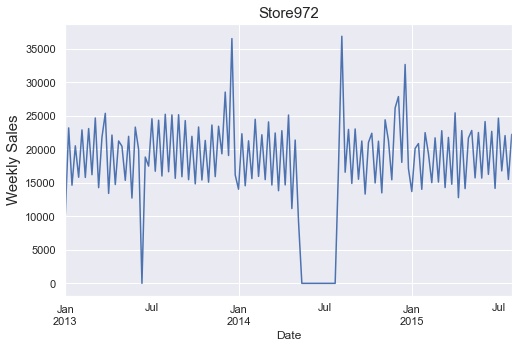

In [8]:
plt.rcParams['figure.figsize'] = (8, 5)
storeweeklysales.plot()
plt.title(f'Store{storeid}', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)
plt.show()

In [9]:
# check stationarity 
sta_result = adfuller(storeweeklysales)
print('ADF Statistic: %f' % sta_result[0])
print('p-value: %f' % sta_result[1])
print('Critical Values:')
for key, value in sta_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.580638
p-value: 0.006142
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


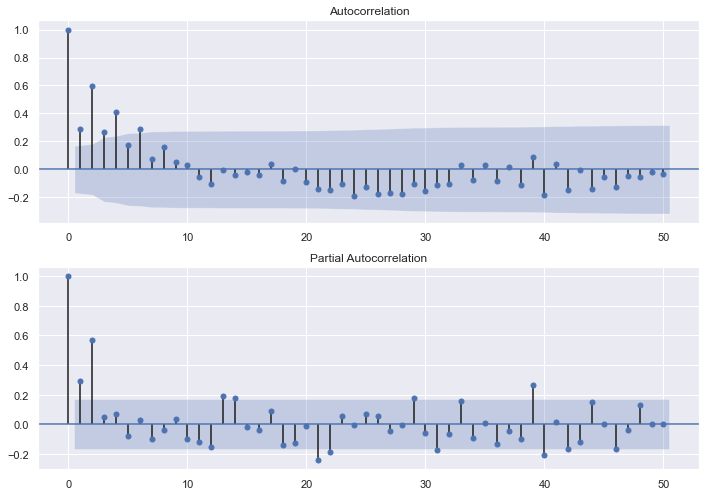

In [10]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
plot_acf(storeweeklysales, lags=50, ax=ax[0])
# ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
# ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
#ax[0].legend()
plot_pacf(storeweeklysales, lags=50, ax=ax[1])
plt.tight_layout()

## Try Mean Method

In [11]:

average = np.full((8,), storeweeklysales[:-9].mean()) # take the average value of  the train set as the predictions of the last 8 weeks 

true_values = storeweeklysales[-9:-1] # last 8 weeks actual sales
mae = mean_absolute_error(true_values, average)

#r2_score(true_values, average)


WAPE = np.sum(abs(average - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
           # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    
           
#print('R2 for average model: {0:.3f}'.format(r2_score(true_values, average)))
print('MAE for average method:{0:.1f}'.format(mae))
print('WAPE for mean method: {0:5f}'.format(WAPE)) 

MAE for average method:3852.6
WAPE for mean method: 0.000083


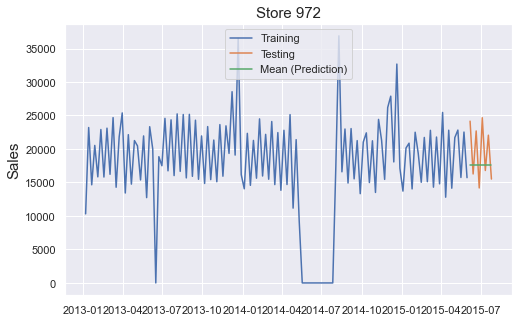

In [42]:
plt.plot(storeweeklysales[:-9],label="Training")
plt.plot(storeweeklysales[-9:-1],label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(storeweeklysales[-9:-1].index, average, label="Mean (Prediction)")
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

# Method 1: Use the whole data set to train model. 
1) When there's no zero value in the data set use the whole dataset to do train test split.

2) When there's zero value in the data set, drop it and use the non-zero value to do train test split. 

In [13]:
storeweeklysales = storeweeklysales[storeweeklysales!=0]

# when there's zero value, the data set will shrink, 
# when there's no zero value, data set will stay the same shape

In [14]:
# storeweeklysales.plot()
# plt.show()

In [15]:
train = storeweeklysales[:-9]
test = storeweeklysales[-9:-1]
print(f'The shape of storeweeklysales is {storeweeklysales.shape}')
print(f'Train set start from {train.index[0]} week,\nends at {train.index[-1]} week')
print(f'Test set start from {test.index[0]} week,\nends at {test.index[-1]} week')

The shape of storeweeklysales is (123,)
Train set start from 2013-01-06 00:00:00 week,
ends at 2015-05-31 00:00:00 week
Test set start from 2015-06-07 00:00:00 week,
ends at 2015-07-26 00:00:00 week


In [16]:
train.shape

(114,)

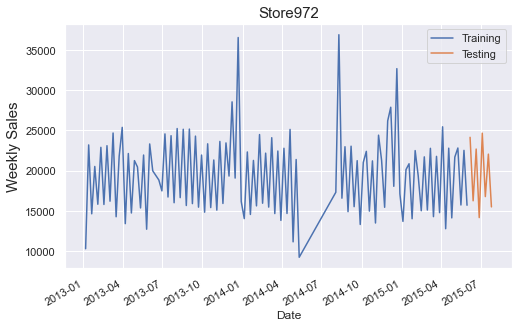

In [17]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

## Auto Arima Model

In [18]:
# for store 262
warnings.filterwarnings("ignore")

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

#predictions = pd.DataFrame(arima_model.predict(n_periods=8), index=test.index)


predictions = arima_model.predict(n_periods=8) # predicitons of last 8 weeks for store 262
true_values = test.values # last 8 weeks actual sales

mae = mean_absolute_error(true_values, predictions)
#R2 = r2_score(true_values, predictions)


WAPE = np.sum(abs(predictions - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
                # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    

#print('R2 for auto_arima model: {0:.3f}'.format(R2))
print('MAE for auto_arima model: {0:.1f}'.format(mae)) 
print('WAPE for auto_arima model: {0:.5f}'.format(WAPE)) 

MAE for auto_arima model: 3955.2
WAPE for auto_arima model: 0.00008


In [19]:
# create data index for forecasting value from week 2015-08-02 to week 2015-09-20

# testindex=storedailydata.set_index('Date').resample('w').Sales.sum()[-9:-1].index
# print(testindex)

forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
print(forecastindex)

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')


In [20]:
arima_model = auto_arima(storeweeklysales[:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)

# forecast = pd.DataFrame(forecast, index=forecastindex)


In [21]:
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,22349.820173,12536.579237,32163.061109
2015-08-09,17810.311041,7878.233015,27742.389068
2015-08-16,21838.927824,10692.620313,32985.235336
2015-08-23,18805.386019,7631.141045,29979.630993
2015-08-30,21659.524399,9868.169825,33450.878973
2015-09-06,19531.099825,7725.113448,31337.086203
2015-09-13,21558.986484,9449.715697,33668.257272
2015-09-20,20003.473543,7886.909411,32120.037675


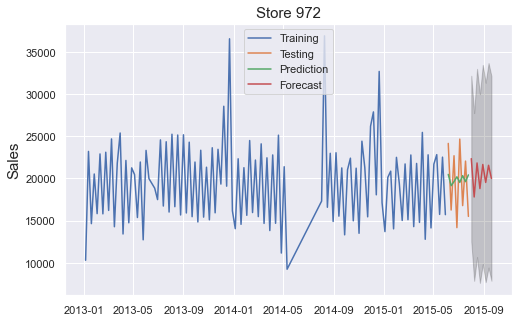

In [22]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

# Method 2: When there's continuing zero value in the data set, separate the data set to 2 parts with continuing zero value in between them, and use the second part to do train test split

In [23]:
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()

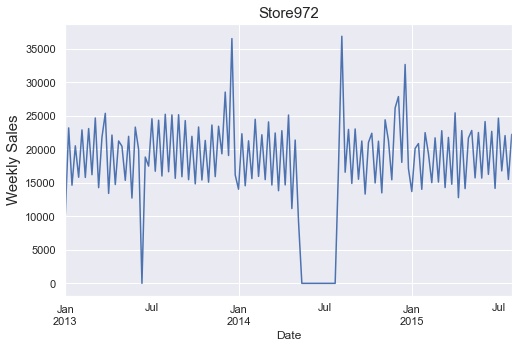

In [24]:
storeweeklysales.plot()
plt.title(f'Store{storeid}', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)
plt.show()

In [25]:
from sys import exit

# if there's zero weekly sales in the data set, 
# filter out the index(week date) of the last week that has zero sales, 
# and our training set should start from the week after it
if len(storeweeklysales[(storeweeklysales == 0)].index) != 0 and len(storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index)>=2:
    train_startdate = storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index[1]


else:
    print('There is no zero value or no enough data after dropping the zero value in the data set')
    exit()

In [26]:
from sys import exit

if len(storeweeklysales.loc[train_startdate:][:-1]) >=16:
    train_enddate = len(storeweeklysales.loc[train_startdate:]) - 9
    train = storeweeklysales.loc[train_startdate:][:train_enddate]
    test = storeweeklysales[-9:-1]
    
else:
    print('Test set does not have enough datas')
    exit()
# if the training set is too short to do 8 weeks prediction (and forecasting) 
# then we will go back to the first methd which is use the whole data set and drop the zero values

In [27]:
print(f'Train set start from week {train.index[0]},\nends at week {train.index[-1]}')
print(f'Test set start from week {test.index[0]},\nends at week {test.index[-1]}')

Train set start from week 2014-08-03 00:00:00,
ends at week 2015-05-31 00:00:00
Test set start from week 2015-06-07 00:00:00,
ends at week 2015-07-26 00:00:00


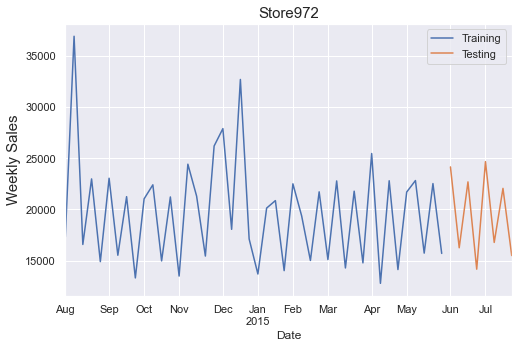

In [28]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

In [29]:
forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
forecastindex

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')

In [30]:
warnings.filterwarnings("ignore")
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

predictions = arima_model.predict(n_periods=8)
#predictions_ci = arima_model.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
#R2 = r2_score(true_values, predictions)
WAPE = np.sum(abs(predictions - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
                # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    
#print('R2 for auto_arima model: {0:.3f}'.format(R2))
print('MAE for auto_arima model: {0:.1f}'.format(mae))     
print('WAPE for auto_arima model: {0:.5f}'.format(WAPE)) 

MAE for auto_arima model: 2465.0
WAPE for auto_arima model: 0.00005


In [31]:
arima_model = auto_arima(storeweeklysales.loc[train_startdate:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,22730.999334,13044.532489,32417.466179
2015-08-09,15617.444632,5864.064536,25370.824728
2015-08-16,22607.177517,11532.223238,33682.131796
2015-08-23,15525.252400,4433.082966,26617.421833
2015-08-30,22514.985285,10244.597690,34785.372880
2015-09-06,15433.060168,3147.132356,27718.987979
2015-09-13,22422.793053,9063.518702,35782.067404
2015-09-20,15340.867935,1967.318607,28714.417264


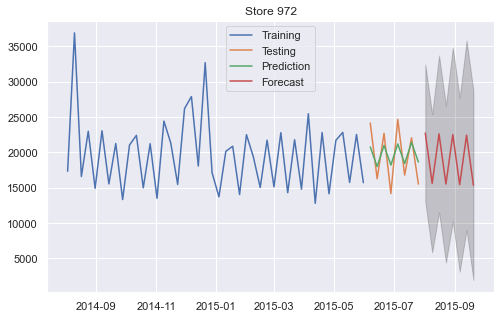

In [32]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}')
plt.legend(loc = 'upper center')
plt.show()

Conclusion: 

MAE for average method:3852.6
<br>WAPE for mean method: 0.000083

MAE for auto_arima model using Method1: 3955.2
<br>WAPE for auto_arima model using Method1: 0.00008


MAE for auto_arima model using method2: 2465.0
<br>brWAPE for auto_arima model using method2: 0.00005

<br> Therefore in the case of store 972, as auto arima method 2 generated better MAE and WAPE than method 1,  and ean method, so we wil use method 2 to do futrue forecasting for Store 972

## Process the steps above by importing class: modelingclass

In [33]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/liuyang/Desktop/Springboard_Capstone3/notebook')
import modelingclass

In [34]:
from modelingclass import modeling

In [35]:
ndf = pd.read_csv('train.csv')
ndf.Date = pd.to_datetime(ndf.Date, format='%Y-%m-%d')

## Get Prediction Performance

In [36]:
modeling(ndf, 972).predict()

,MAE_AutoArima,WAPE_AutoArima,MAE_MeanMethod,WAPE_MeanMethod
972,2465.029034,0.000053,3852.625,0.000083


## Get Forecast Result

In [37]:
webresult = modeling(ndf, 972).forecast('2015-07-27', '2015-09-20')

webresult

,Forecast,lower CI,upper CI,Previous 8 Weeks
2015-08-02,22730.999334,13044.532489,32417.466179,24152.0
2015-08-09,15617.444632,5864.064536,25370.824728,16268.0
2015-08-16,22607.177517,11532.223238,33682.131796,22692.0
2015-08-23,15525.252400,4433.082966,26617.421833,14180.0
2015-08-30,22514.985285,10244.597690,34785.372880,24666.0
2015-09-06,15433.060168,3147.132356,27718.987979,16789.0
2015-09-13,22422.793053,9063.518702,35782.067404,22059.0
2015-09-20,15340.867935,1967.318607,28714.417264,15511.0


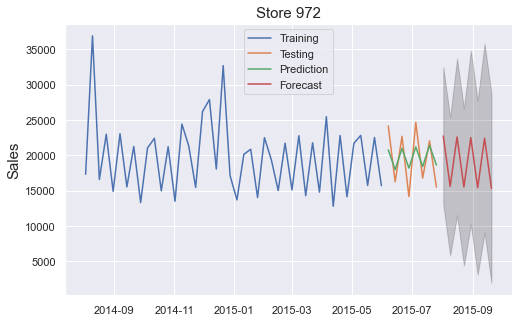

In [38]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

In [39]:
# # visualize the forecast plot

# fig = go.Figure([
#      go.Scatter(
#         name='Previous 8 Weeks',
#         x=storeweeklysales[-9:-1].index,
#         y=webresult['Previous 8 Weeks'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#      go.Scatter(
#         hoverinfo='none',
#         name='',
#         x=[storeweeklysales[-9:-1].index[-1], webresult.index[0]],
#         y=[storeweeklysales[-9:-1].values[-1], webresult['Forecast'][0]], 
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Forcast',
#         x=webresult.index,
#         y=webresult['Forecast'],
#         mode='lines',
#         line=dict(color='rgb(255,0,0)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=webresult.index,
#         y=webresult['upper CI'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=webresult.index,
#         y=webresult['lower CI'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])
# fig.update_layout(
#     width=700,
#     height=400,
#     title=f'Store 909',
#     yaxis_title='Weekly Sales ',
#     hovermode="x"
# )
# fig.show()

## Get MAE, WAPE result for prediction

model_eval_1_to_100 = []
for i in range(1, 101):
    model_eval_1_to_100 .append(modeling(ndf, i).predict().iloc[0,:].values)

model_eval_101_to_200 = []
for i in range(101, 201):
    model_eval_101_to_200.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_1_to_100), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
            ).to_csv('model_eval_1_to_100.csv', index=False)

pd.DataFrame(np.array(model_eval_101_to_200), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
            ).to_csv('model_eval_101_to_200.csv', index=False)

# pd.read_csv('model_eval_1_to_100.csv').loc[99]

model_eval_201_to_300 = []
for i in range(201, 301):
    model_eval_201_to_300.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_201_to_300), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_201_to_300.csv', index=False)

model_eval_301_to_400 = []
for i in range(301, 401):
    model_eval_301_to_400.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_301_to_400), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_301_to_400.csv', index=False)

model_eval_401_to_500 = []
for i in range(401, 501):
    model_eval_401_to_500.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_401_to_500), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_401_to_500.csv', index=False)

model_eval_501_to_600 = []
for i in range(501, 601):
    model_eval_501_to_600.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_501_to_600), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_501_to_600.csv', index=False)

model_eval_601_to_700 = []
for i in range(601, 701):
    model_eval_601_to_700.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_601_to_700), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_601_to_700.csv', index=False)

model_eval_701_to_800 = []
for i in range(701, 801):
    model_eval_701_to_800.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_701_to_800), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_701_to_800.csv', index=False)

model_eval_801_to_900 = []
for i in range(801, 901):
    model_eval_801_to_900.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_801_to_900), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_801_to_900.csv', index=False)

model_eval_901_to_1000 = []
for i in range(901, 1001):
    model_eval_901_to_1000.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_901_to_1000), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_901_to_1000.csv', index=False)

model_eval_1001_to_1100 = []
for i in range(1001, 1101):
    model_eval_1001_to_1100.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_1001_to_1100), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_1001_to_1100.csv', index=False)

model_eval_1101_to_1115= []
for i in range(1101, 1116):
    model_eval_1101_to_1115.append(modeling(ndf, i).predict().iloc[0,:].values)

pd.DataFrame(np.array(model_eval_1101_to_1115), 
             columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
          ).to_csv('model_eval_1101_to_1115.csv', index=False)

In [40]:
# import warnings
# warnings.filterwarnings("ignore")
# import numpy as np
# import pandas as pd
# from pmdarima.arima import auto_arima
# from sklearn.metrics import mean_absolute_error
# #from sklearn.metrics import r2_score


# class modeling:
#     warnings.filterwarnings("ignore")

#     def __init__(self, data, storeid):
#         self.data = data
#         self.storeid = storeid
#         self.storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
#         self.average = np.full((8,), self.storeweeklysales[:-9].mean())
#         self.mae = mean_absolute_error(self.storeweeklysales[-9:-1], self.average)
#         self.WAPE = np.sum(abs(self.average - self.storeweeklysales[-9:-1]))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
 
           
 

#     def predict(self):
#         #storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
    
#         if len(self.storeweeklysales[(self.storeweeklysales == 0)].index) == 0:
#             train, test = (self.storeweeklysales[:-9], self.storeweeklysales[-9:-1])
#             arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult1 = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae = mean_absolute_error(true_values, predictresult1)
#             WAPE = np.sum(abs(predictresult1 - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
            
#             #R2 = r2_score(true_values, predictresult1)
#             return pd.DataFrame([mae, WAPE,  self.mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'], columns=[self.storeid]).T
#             #return pd.DataFrame([mae, R2])

#         if len(self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index)>=2 and len(self.storeweeklysales.loc[self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]:][:-1]) >= 16:
#             train_startdate = self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]
#             train_enddate = len(self.storeweeklysales.loc[train_startdate:]) - 9
#             train = self.storeweeklysales.loc[train_startdate:][:train_enddate]
#             #test = self.storeweeklysales.loc[train_startdate:][train_enddate:-1]
#             test = self.storeweeklysales[-9:-1]

#             arima_model = auto_arima(train, start_p=0, d=0,
#                                      start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae_2 = mean_absolute_error(true_values, predictresult)
#             WAPE_2 = np.sum(abs(predictresult - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
#             #R2_2 = r2_score(true_values, predictresult)
#             return pd.DataFrame([mae_2, WAPE_2, self. mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod', 'WAPE_MeanMethod'], columns=[self.storeid]).T
#             #return pd.DataFrame([mae_2, R2_2])

#         else:
#             storeweeklysales_dropzero = self.storeweeklysales[self.storeweeklysales != 0]
#             train, test = (storeweeklysales_dropzero[:-9], storeweeklysales_dropzero[-9:-1])
#             arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult1 = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae = mean_absolute_error(true_values, predictresult1)
#             WAPE = np.sum(abs(predictresult1 - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
#             #R2 = r2_score(true_values, predictresult1)
#             return pd.DataFrame([mae, WAPE, self.mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod', 'WAPE_MeanMethod' ], columns=[self.storeid]).T
#             #return pd.DataFrame([mae, R2])

#     def forecast(self, start_date, end_date):
#         # storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
#         # storeweeklysales = storeweeklysales[storeweeklysales!=0]
#         forecastindex = pd.date_range(start_date, end_date, freq='W')
#         if len(self.storeweeklysales[(self.storeweeklysales == 0)].index) == 0:
#             train, test = (self.storeweeklysales[:-9], self.storeweeklysales[-9:-1])
#             arima_model = auto_arima(self.storeweeklysales[:test.index[-1]], start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             forecastresult1 = pd.DataFrame([forecast, CI[:, 0], CI[:, 1]],
#                                            index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)
#             forecastresult1['Previous 8 Weeks'] = self.storeweeklysales[-9:-1].values
#             return forecastresult1

#         if len(self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index)>=2 and len(self.storeweeklysales.loc[self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]:][:-1]) >= 16:
#             train_startdate = self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]
#             train_enddate = len(self.storeweeklysales.loc[train_startdate:]) - 9
#             train = self.storeweeklysales.loc[train_startdate:][:train_enddate]
#             #test = self.storeweeklysales.loc[train_startdate:][train_enddate:-1]
#             test = self.storeweeklysales[-9:-1]

#             arima_model = auto_arima(self.storeweeklysales.loc[train_startdate:test.index[-1]], start_p=0, d=0,
#                                      start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             return pd.DataFrame([forecast, CI[:, 0], CI[:, 1], self.storeweeklysales[-9:-1].values],
#                                 index=['Forecast', 'lower CI', 'upper CI', 'Previous 8 Weeks']).T.set_index(forecastindex)


#         else:
#             storeweeklysales_dropzero = self.storeweeklysales[self.storeweeklysales != 0]
#             train, test = (storeweeklysales_dropzero[:-9], storeweeklysales_dropzero[-9:-1])
#             arima_model = auto_arima(storeweeklysales_dropzero[:test.index[-1]], start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             forecastresult1 = pd.DataFrame([forecast, CI[:, 0], CI[:, 1]],
#                                            index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

#             forecastresult1['Previous 8 Weeks'] = self.storeweeklysales[-9:-1].values
#             return forecastresult1

In [41]:
#special store number 
# 292
# 876